<h2> Spatial & Temporal MBA Data Tests </h2>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>
<br>
<h7>4/21/22</h7>


In [3]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [107]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery
import warnings




os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> SQL Queries

In [5]:
# list of unique tiers per ISP and tech

uniquetiers = """
SELECT DISTINCT mt.download,mt.ISP, mt.Technology,COUNT(DISTINCT httpmt.unit_id) as totalBoxes,

FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id

GROUP BY mt.download,mt.ISP, mt.Technology
HAVING totalBoxes >= 30
ORDER BY mt.download

"""
uniquetiers= client.query(uniquetiers).to_dataframe()
print(uniquetiers)

    download              ISP Technology  totalBoxes
0        1.5      CenturyLink        DSL          65
1        3.0      CenturyLink        DSL          50
2        5.0  Cincinnati Bell        DSL          49
3        6.0         Frontier        DSL          36
4       10.0      CenturyLink        DSL          73
5       10.0       Windstream        DSL          56
6       12.0         Frontier        DSL          66
7       12.0      CenturyLink        DSL          66
8       12.0       Windstream        DSL          51
9       15.0       Windstream        DSL          46
10      18.0         Frontier        DSL          44
11      20.0      CenturyLink        DSL          57
12      25.0      CenturyLink        DSL          87
13      25.0          Comcast      Cable          57
14      25.0       Windstream        DSL          56
15      30.0  Cincinnati Bell        DSL          31
16      40.0      CenturyLink        DSL          57
17      50.0              Cox      Cable      

In [6]:
# function that allows you to get 95th consistent speed during peak hours for particular tier and ISP
# Function used to get speed for main sql queries

def get5th(downloadTier, isp):
    
    isp = "'"+isp+"'"

    fifthQuery = """
        SELECT 
        mt.download,
        mt.ISP,
        mt.Technology,
        APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as fifthPct,
        COUNT(DISTINCT httpmt.unit_id) as totalBoxes,
        FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
            INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
            ON httpmt.unit_id=mt.unit_id
        WHERE mt.download = {} and mt.ISP = {}
        AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
        GROUP BY mt.download, mt.ISP, mt.Technology
        """.format(downloadTier, isp)
    df= client.query(fifthQuery).to_dataframe()
#     print(df)
    
    return(float(df['fifthPct']))




<h3>Main SQL Queries </h3>

In [7]:
# 5th pct speed for windstream 50 mbps: peak = 29.8516, peak median = 42.628344 totalBoxes = 32
# 5th pct speed for windstream 100 mbps: nonpeak = 73.543872, peak = 74.440792, peak median= 100.593248 totalBoxes=34
# 5th pct speed for Comcast 500 mbps: nonpeak = 139.989232, peak = 195.859112, totalBoxes = 12
# 5th pct speed for Mediacom 500 mbps: nonpeak = 422.247576, peak = 393.978344, peak median =569.977616, totalboxes=43
# 5th pct speed for Frontier 500 mbps: nonpeak = 387.65412, peak = 350.104624, total boxes = 69




windstream50SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State, 
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 50 AND mt.ISP = "Windstream"
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(50, "Windstream"))


windstream100SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 100 AND mt.ISP = "Windstream" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude 
ORDER BY LowSpeed5PctCount
""".format(get5th(100, "Windstream"))

comcast500SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 500 AND mt.ISP = "Comcast" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(500, "Comcast"))

mediacom500SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 500 AND mt.ISP = "Mediacom" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(500, "Mediacom"))

frontier500SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 500 AND mt.ISP = "Frontier" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(500, "Frontier"))


comcast100SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 100 AND mt.ISP = "Comcast" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(100, "Comcast"))


verizonfiber100SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 100 AND mt.ISP = "Verizon" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(100, "Verizon"))


mediacom100SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 100 AND mt.ISP = "Mediacom" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(100, "Mediacom"))


charter100SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= {} THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
geo.latitude as latitude, 
geo.longitude as longitude,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
    INNER JOIN `broadband-data.mba_data.geocoded-units-sept2020` as geo 
    ON geo.unit_id=mt.unit_id 
WHERE mt.download = 100 AND mt.ISP = "Charter" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, latitude, longitude
ORDER BY LowSpeed5PctCount
""".format(get5th(100, "Charter"))



windstream50 = client.query(windstream50SQL).to_dataframe()
windstream100 = client.query(windstream100SQL).to_dataframe()
comcast500 = client.query(comcast500SQL).to_dataframe()
mediacom500 = client.query(mediacom500SQL).to_dataframe()
frontier500 = client.query(frontier500SQL).to_dataframe()

comcast100 = client.query(comcast100SQL).to_dataframe()
verizonfiber100 = client.query(verizonfiber100SQL).to_dataframe()
mediacom100 = client.query(mediacom100SQL).to_dataframe()
charter100 = client.query(charter100SQL).to_dataframe()



print('executed')



executed


In [8]:
# Creating new dataframes for scatter plots sorted by 95th consistent speed
windstream50['5PctNorm'] = windstream50['slow5Pct']/windstream50['Download']*100
windstream50['MedianNorm'] = windstream50['medianSpeedMbps']/windstream50['Download']*100
windstream50Scatter = windstream50.sort_values(by=['5PctNorm'], ascending = False)

windstream100['5PctNorm'] = windstream100['slow5Pct']/windstream100['Download']*100
windstream100['MedianNorm'] = windstream100['medianSpeedMbps']/windstream100['Download']*100
windstream100Scatter = windstream100.sort_values(by=['5PctNorm'], ascending = False)

comcast500['5PctNorm'] = comcast500['slow5Pct']/comcast500['Download']*100
comcast500['MedianNorm'] = comcast500['medianSpeedMbps']/comcast500['Download']*100
comcast500Scatter = comcast500.sort_values(by=['5PctNorm'], ascending = False)

mediacom500['5PctNorm'] = mediacom500['slow5Pct']/mediacom500['Download']*100
mediacom500['MedianNorm'] = mediacom500['medianSpeedMbps']/mediacom500['Download']*100
mediacom500Scatter = mediacom500.sort_values(by=['5PctNorm'], ascending = False)

frontier500['5PctNorm'] = frontier500['slow5Pct']/frontier500['Download']*100
frontier500['MedianNorm'] = frontier500['medianSpeedMbps']/frontier500['Download']*100
frontier500Scatter = frontier500.sort_values(by=['5PctNorm'], ascending = False)



comcast100['5PctNorm'] = comcast100['slow5Pct']/comcast100['Download']*100
comcast100['MedianNorm'] = comcast100['medianSpeedMbps']/comcast100['Download']*100
comcast100Scatter = comcast100.sort_values(by=['5PctNorm'], ascending = False)


verizonfiber100['5PctNorm'] = verizonfiber100['slow5Pct']/verizonfiber100['Download']*100
verizonfiber100['MedianNorm'] = verizonfiber100['medianSpeedMbps']/verizonfiber100['Download']*100
verizonfiber100Scatter = verizonfiber100.sort_values(by=['5PctNorm'], ascending = False)


mediacom100['5PctNorm'] = mediacom100['slow5Pct']/mediacom100['Download']*100
mediacom100['MedianNorm'] = mediacom100['medianSpeedMbps']/mediacom100['Download']*100
mediacom100Scatter = mediacom100.sort_values(by=['5PctNorm'], ascending = False)

charter100['5PctNorm'] = charter100['slow5Pct']/charter100['Download']*100
charter100['MedianNorm'] = charter100['medianSpeedMbps']/charter100['Download']*100
charter100Scatter = charter100.sort_values(by=['5PctNorm'], ascending = False)

print('executed')


executed


<h2>Additional Scatter Charts</h2>

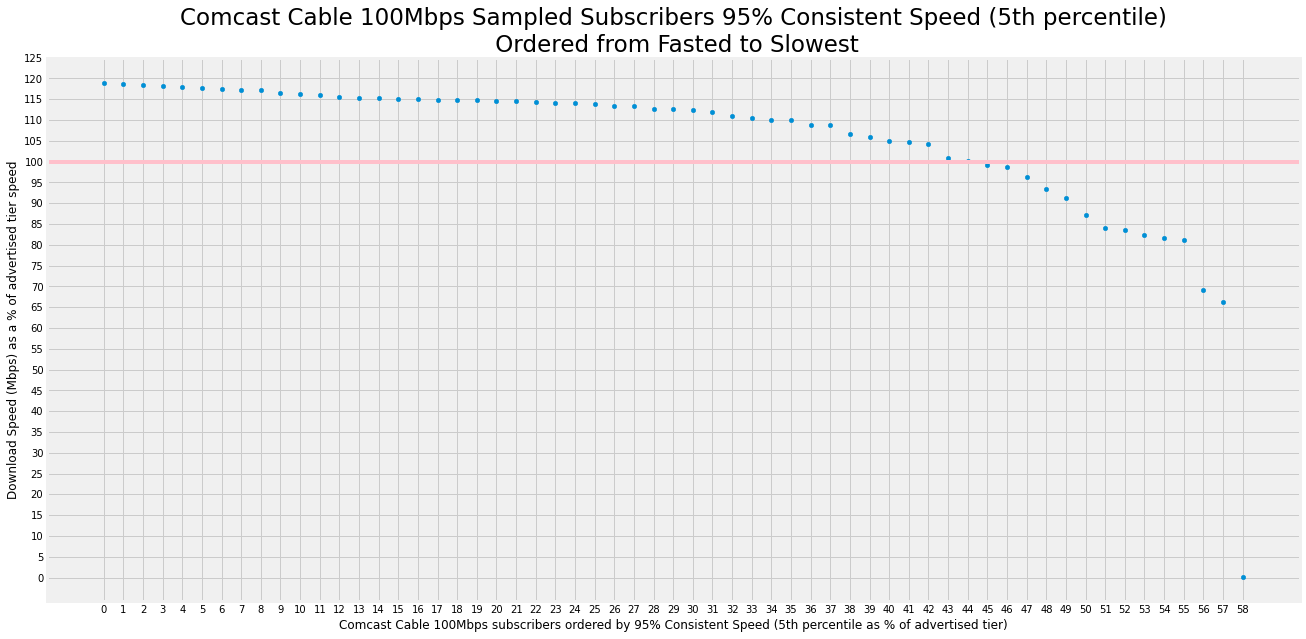

In [9]:
x=[]
for i in range(len(comcast100Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = comcast100Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 130, 5))
plt.xticks(np.arange(0, len(comcast100Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Comcast Cable 100Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Comcast Cable 100Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

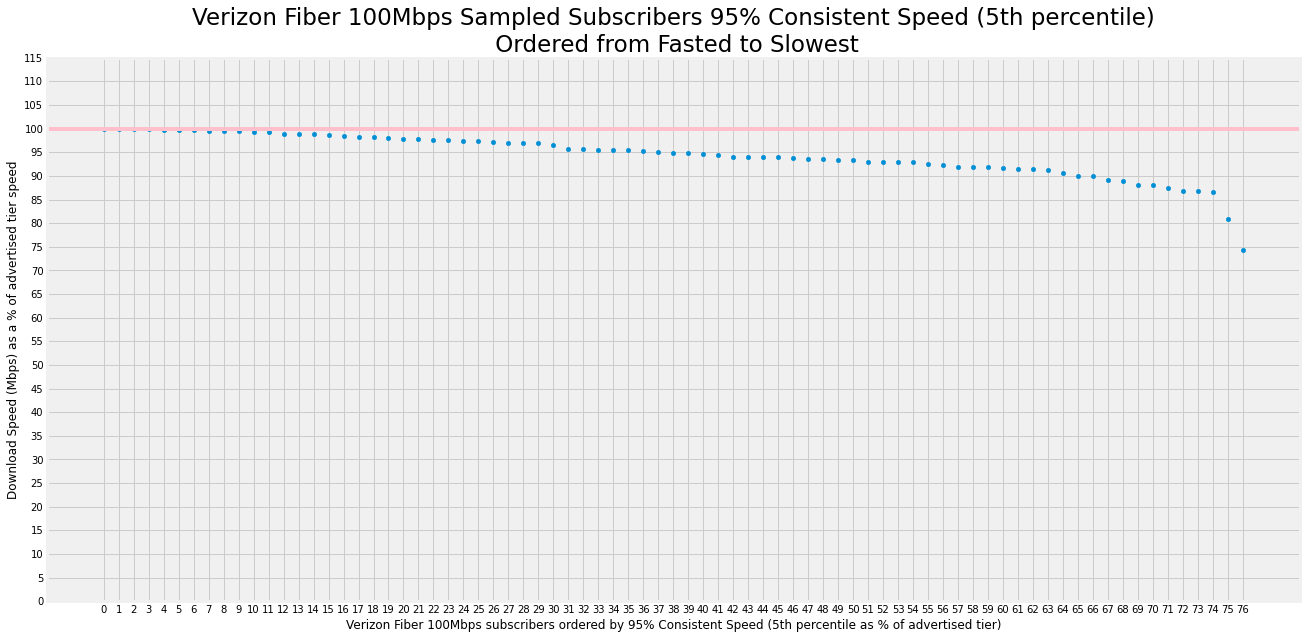

In [10]:
x=[]
for i in range(len(verizonfiber100Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = verizonfiber100Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 120, 5))
plt.xticks(np.arange(0, len(verizonfiber100Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Verizon Fiber 100Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Verizon Fiber 100Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

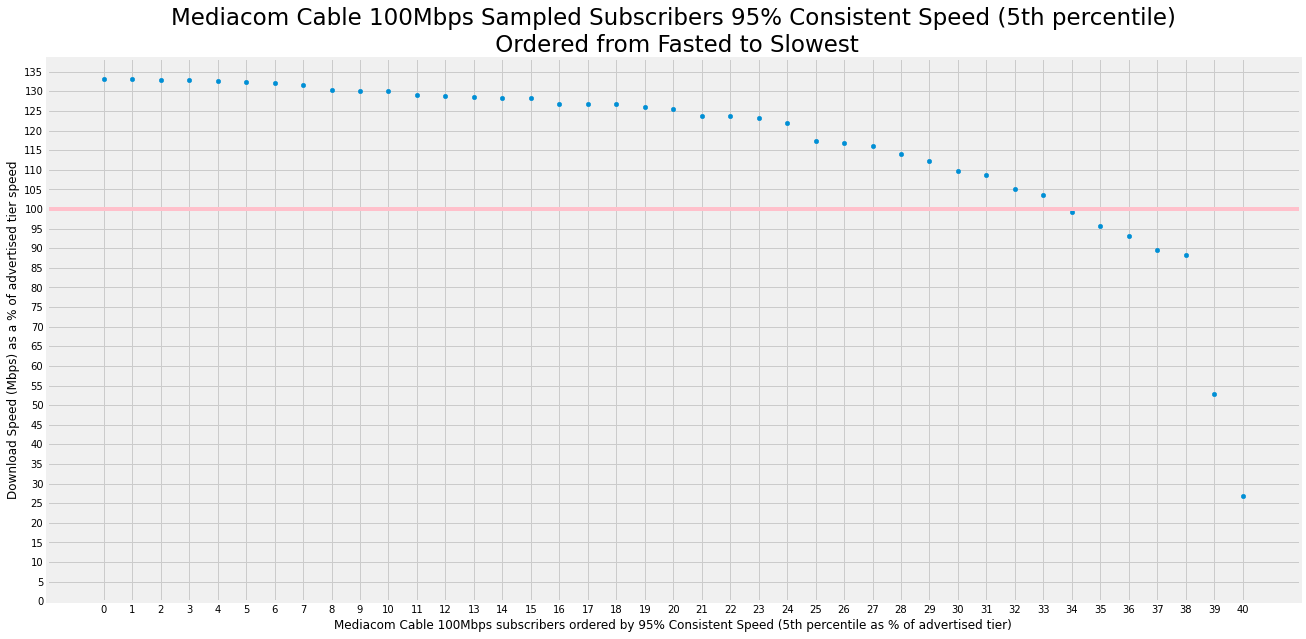

In [11]:
x=[]
for i in range(len(mediacom100Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = mediacom100Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 140, 5))
plt.xticks(np.arange(0, len(mediacom100Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Mediacom Cable 100Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Mediacom Cable 100Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

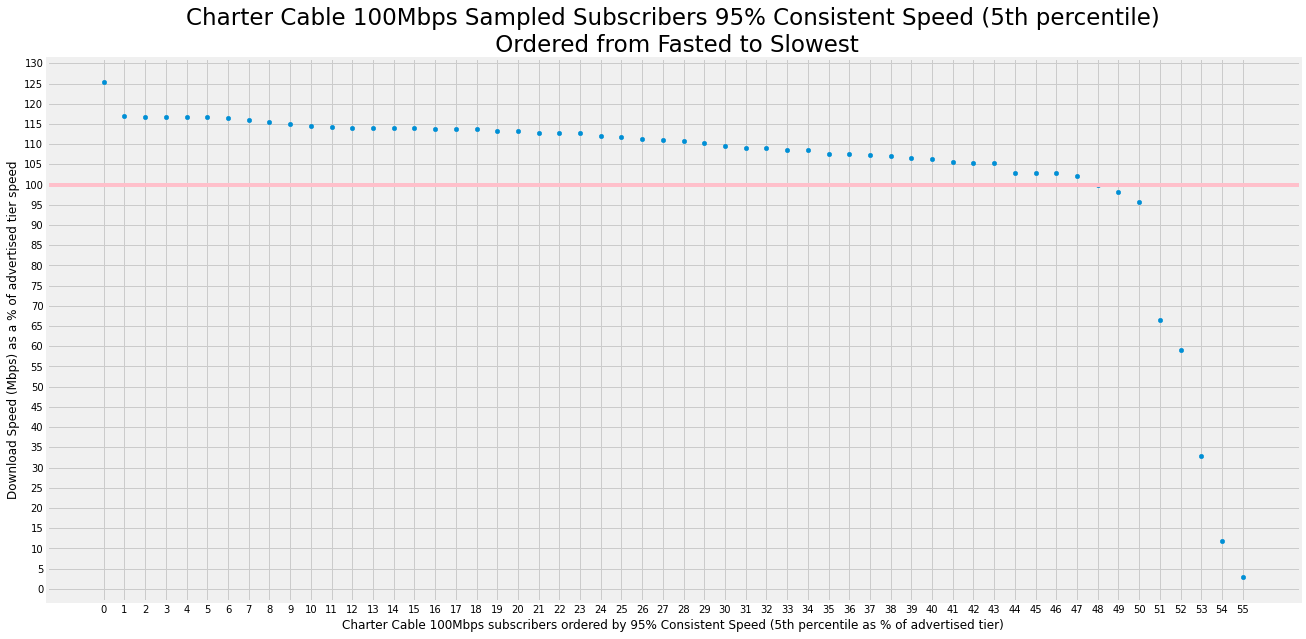

In [12]:
x=[]
for i in range(len(charter100Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = charter100Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 135, 5))
plt.xticks(np.arange(0, len(charter100Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Charter Cable 100Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Charter Cable 100Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

<hr>

<h3>Plotting subscribers per tier on map </h3>

In [22]:
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon 
import descartes


usMap = geopandas.read_file('tl_2020_us_state/tl_2020_us_state.shp')
nonContiguous = ['United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands', 
                'Guam', 'American Samoa', 'Alaska', 'Puerto Rico', 'Hawaii',]


usMap = usMap[~usMap['NAME'].isin(nonContiguous)]
print('Done')

Done


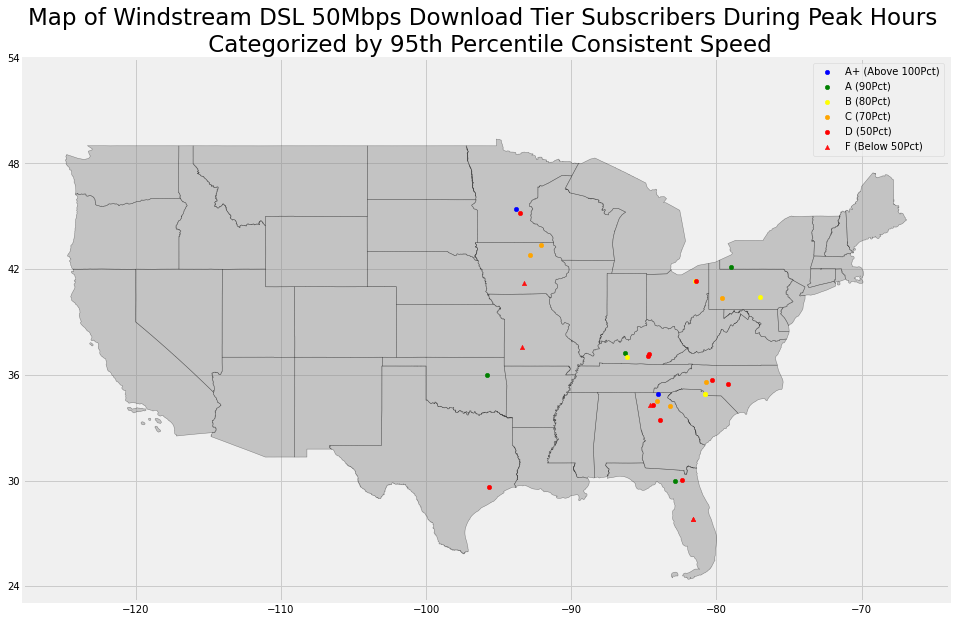

In [102]:
fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(windstream50Scatter['longitude'], windstream50Scatter['latitude'])]
comcastGeo = GeoDataFrame(windstream50Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Windstream DSL 50Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()

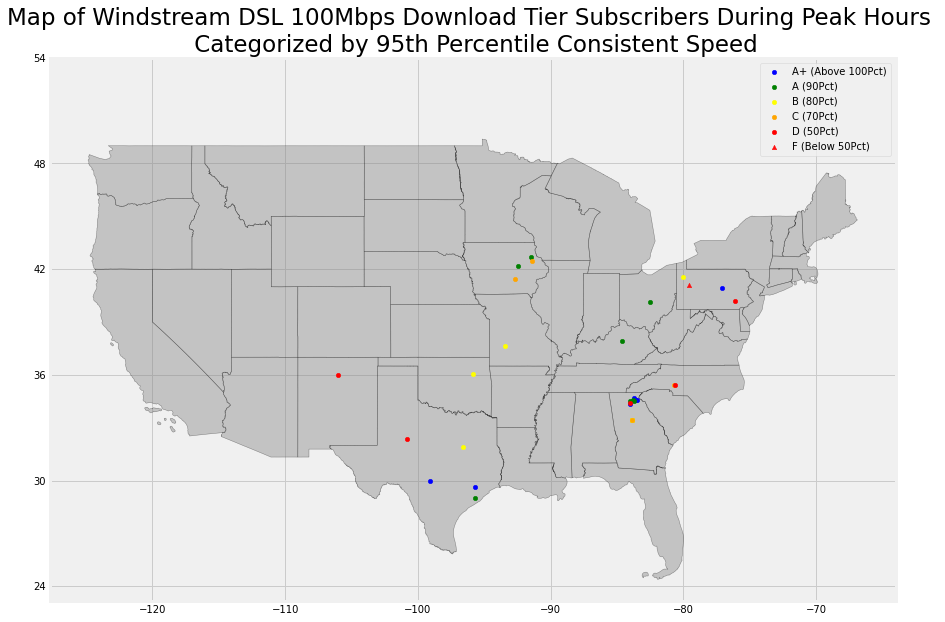

In [103]:
fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(windstream100Scatter['longitude'], windstream100Scatter['latitude'])]
geo = GeoDataFrame(windstream100Scatter, crs = 4326, geometry = geometry)

geo[geo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
geo[(geo['5PctNorm'] >= 90) & (geo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
geo[(geo['5PctNorm'] >=80) & (geo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
geo[(geo['5PctNorm'] >=70) & (geo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
geo[(geo['5PctNorm'] >=50) & (geo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
geo[geo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Windstream DSL 100Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()

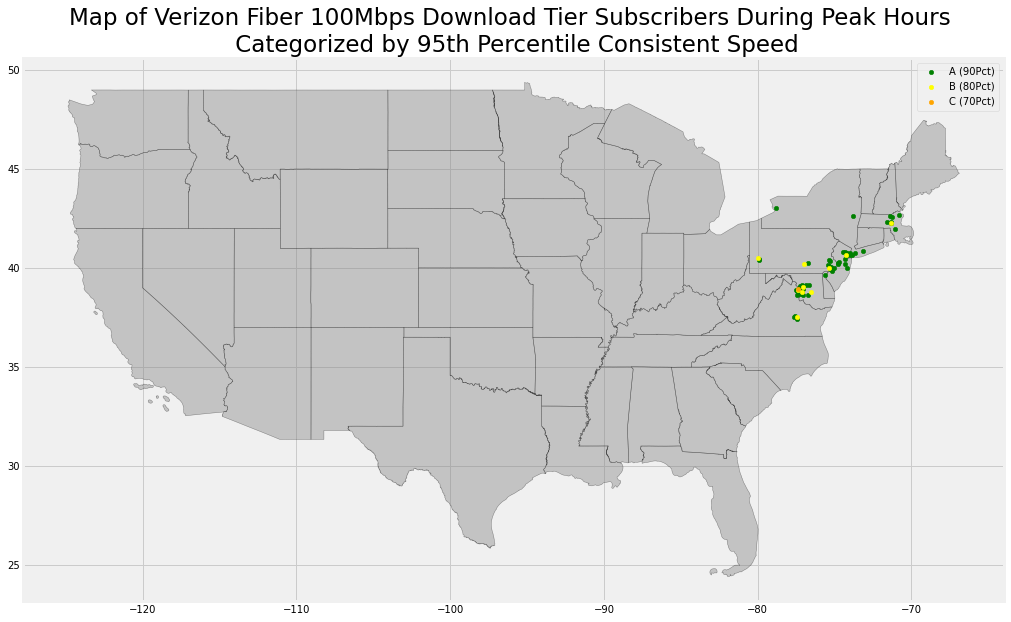

In [106]:
warnings.filterwarnings('ignore')
crs = {"init": "epsg:4326"}
geometry = [Point(xy) for xy in zip(verizonfiber100Scatter['longitude'], verizonfiber100Scatter['latitude'])]
geoVerizon100 = GeoDataFrame(verizonfiber100Scatter, crs = crs, geometry=geometry)




fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')




# geoVerizon100[geoVerizon100['5PctNorm'] > 100.0].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',
#                                   label = 'A+ (Above 100Pct)')
geoVerizon100[(geoVerizon100['5PctNorm'] >= 90.0) & (geoVerizon100['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, 
                                                                color = 'green',marker = 'o',
                                                                label = 'A (90Pct)')
geoVerizon100[(geoVerizon100['5PctNorm'] >=80) & (geoVerizon100['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',
                                                             marker = 'o',label = 'B (80Pct)')
geoVerizon100[(geoVerizon100['5PctNorm'] >=70) & (geoVerizon100['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',
                                                             marker = 'o',label = 'C (70Pct)')
# geoVerizon100[(geoVerizon100['5PctNorm'] >=50) & (geoVerizon100['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',
#                                                              marker = 'o',label = 'D (50Pct)')
# geoVerizon100[geoVerizon100['5PctNorm'] < 50].plot(ax = ax , markersize = 100, color = '#ff0f0f',marker = 'o',
#                                  label = 'F (Below 50Pct)')
plt.title("""Map of Verizon Fiber 100Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)

plt.legend()



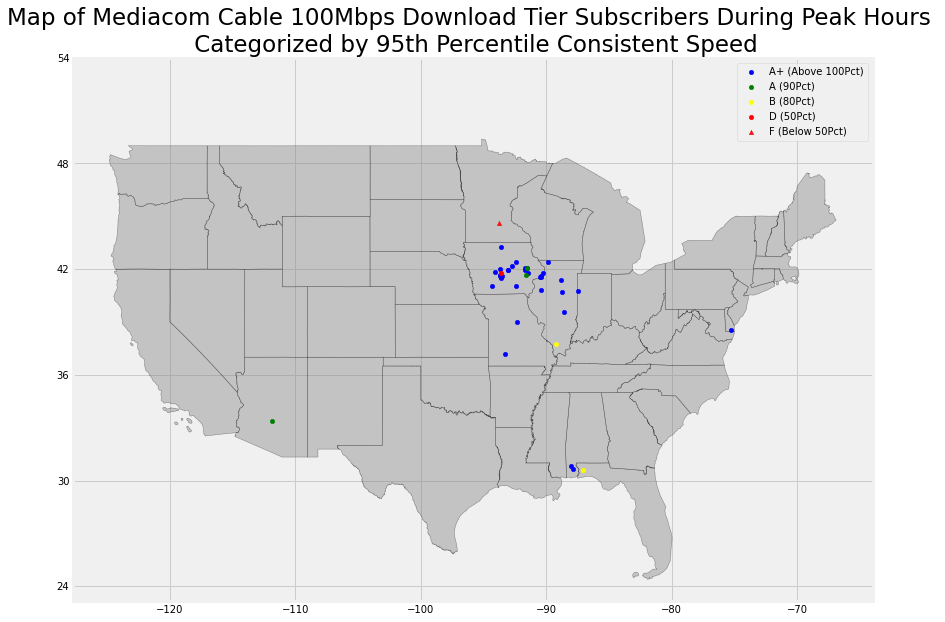

In [92]:
warnings.filterwarnings('ignore')

fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(mediacom100Scatter['longitude'], mediacom100Scatter['latitude'])]
comcastGeo = GeoDataFrame(mediacom100Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Mediacom Cable 100Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()

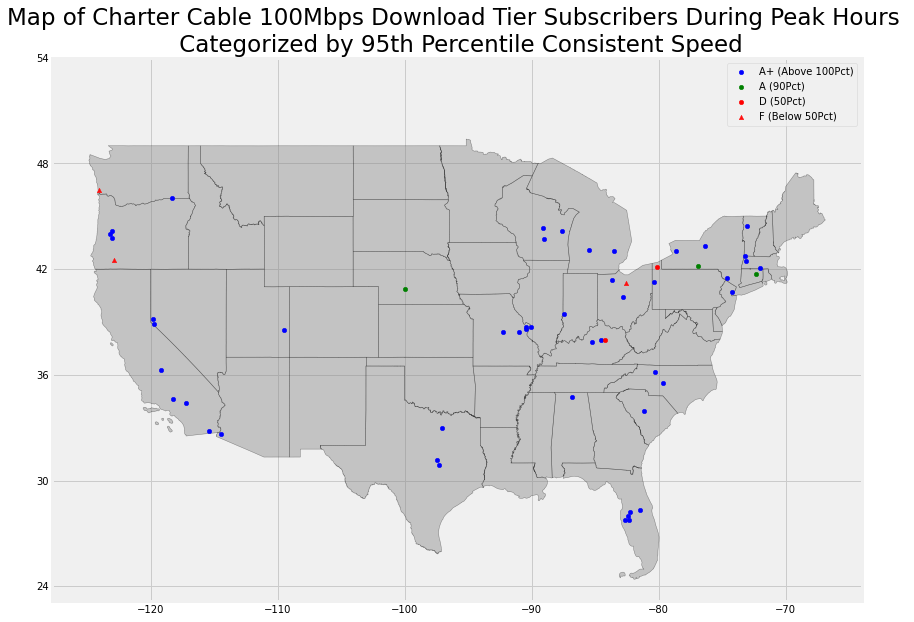

In [104]:
warnings.filterwarnings('ignore')

fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(charter100Scatter['longitude'], charter100Scatter['latitude'])]
comcastGeo = GeoDataFrame(charter100Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Charter Cable 100Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()

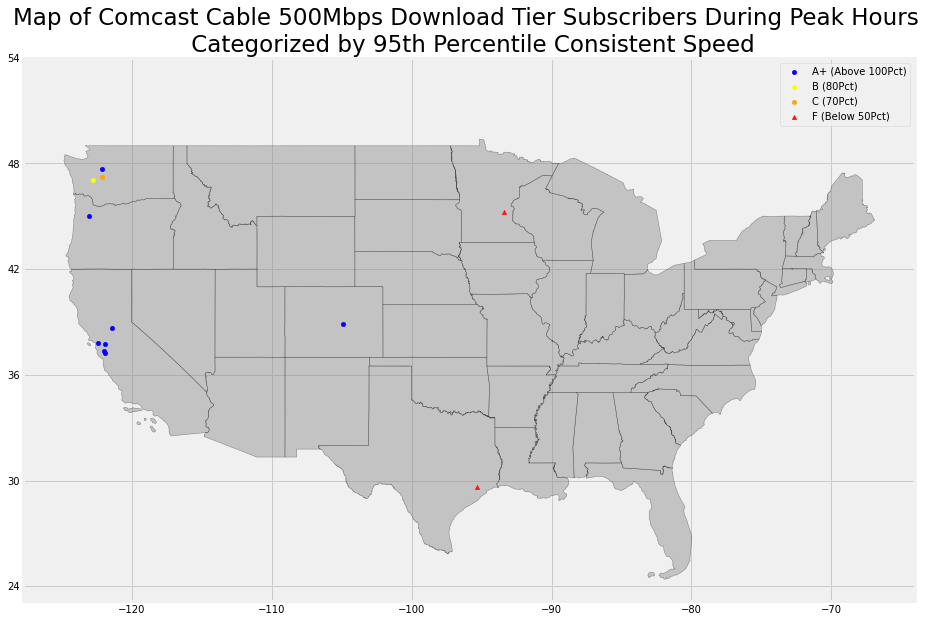

In [94]:
warnings.filterwarnings('ignore')


fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(comcast500Scatter['longitude'], comcast500Scatter['latitude'])]
comcastGeo = GeoDataFrame(comcast500Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Comcast Cable 500Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()

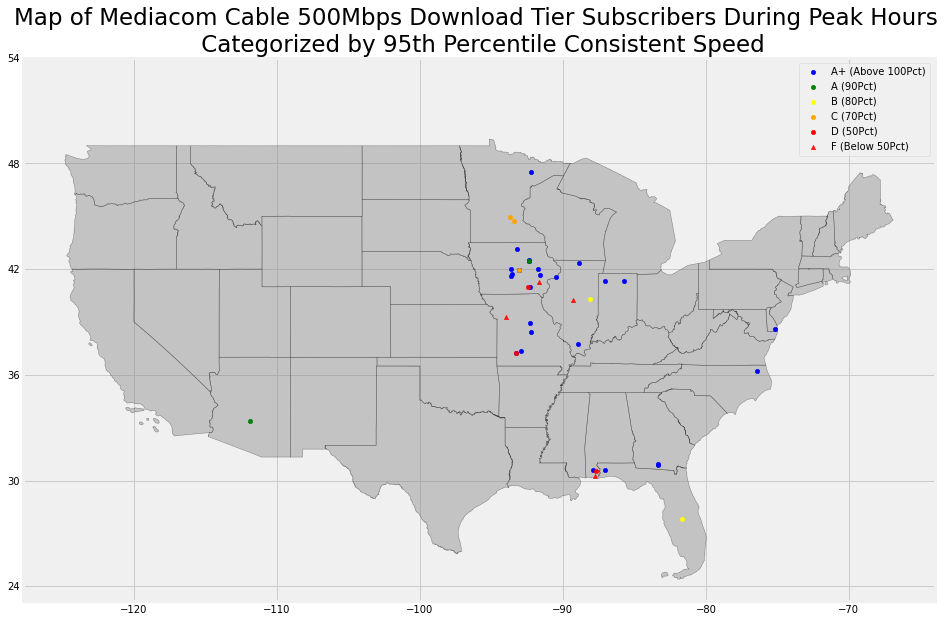

In [95]:
warnings.filterwarnings('ignore')


fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(mediacom500Scatter['longitude'], mediacom500Scatter['latitude'])]
comcastGeo = GeoDataFrame(mediacom500Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Mediacom Cable 500Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


warnings.filterwarnings('ignore')
plt.legend()

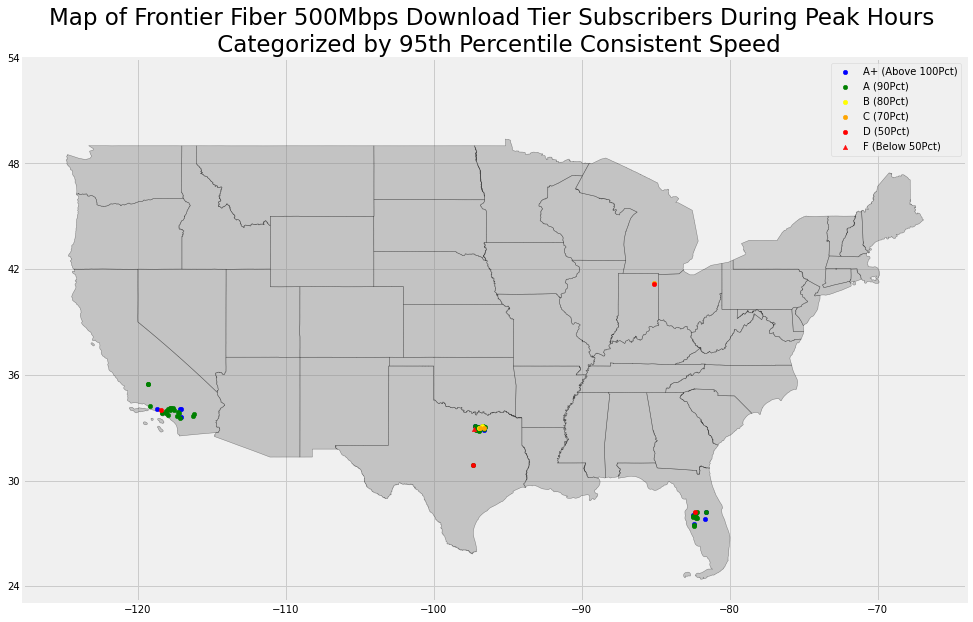

In [96]:
warnings.filterwarnings('ignore')


fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(frontier500Scatter['longitude'], frontier500Scatter['latitude'])]
comcastGeo = GeoDataFrame(frontier500Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))

plt.title("""Map of Frontier Fiber 500Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()

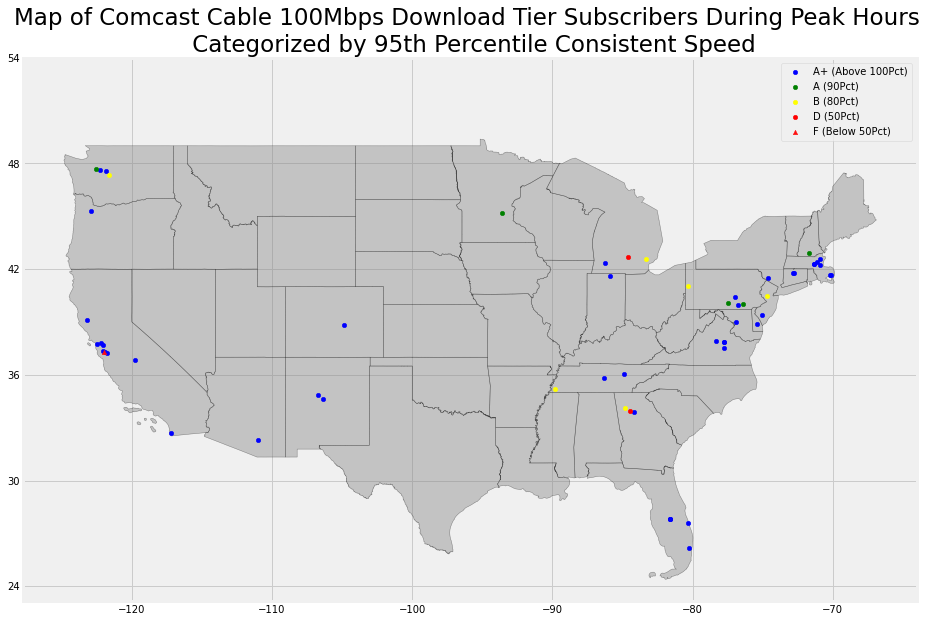

In [97]:
warnings.filterwarnings('ignore')


fix, ax = plt.subplots(figsize = (30,10))
usMap.plot(ax=ax, color="gray", alpha=.4, edgecolor='black')

geometry = [Point(xy) for xy in zip(comcast100Scatter['longitude'], comcast100Scatter['latitude'])]
comcastGeo = GeoDataFrame(comcast100Scatter, crs = 4326, geometry = geometry)

comcastGeo[comcastGeo['5PctNorm'] > 100].plot(ax = ax , markersize = 20, color = 'blue',marker = 'o',label = 'A+ (Above 100Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >= 90) & (comcastGeo['5PctNorm'] <=100)].plot(ax = ax , markersize = 20, color = 'green',marker = 'o',label = 'A (90Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=80) & (comcastGeo['5PctNorm'] <90)].plot(ax = ax , markersize = 20, color = 'yellow',marker = 'o',label = 'B (80Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=70) & (comcastGeo['5PctNorm'] <80)].plot(ax = ax , markersize = 20, color = 'orange',marker = 'o',label = 'C (70Pct)')
comcastGeo[(comcastGeo['5PctNorm'] >=50) & (comcastGeo['5PctNorm'] <70)].plot(ax = ax , markersize = 20, color = 'red',marker = 'o',label = 'D (50Pct)')
comcastGeo[comcastGeo['5PctNorm'] < 50].plot(ax = ax , markersize = 20, color = '#ff0f0f',marker = '^',label = 'F (Below 50Pct)')

plt.yticks(np.arange(24, 60, 6))


plt.title("""Map of Comcast Cable 100Mbps Download Tier Subscribers During Peak Hours \n Categorized by 95th Percentile Consistent Speed""", fontsize=23)


plt.legend()








<hr>

In [65]:
windstream50

,unit_id,ISP,Technology,Download,State,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,latitude,longitude,5PctNorm,MedianNorm
0,26226285,Windstream,DSL,50.0,GA,0,0,52.344768,52.424480,52.418480,34.936222,-83.996538,104.689536,104.836960
1,3942113,Windstream,DSL,50.0,IA,0,0,37.333032,42.093816,41.756240,42.826430,-92.807657,74.666064,83.512480
2,9967,Windstream,DSL,50.0,NC,0,0,35.972904,42.598816,42.563296,35.592040,-80.686625,71.945808,85.126592
3,939554,Windstream,DSL,50.0,MN,0,0,34.051272,42.080216,41.591368,45.189990,-93.558751,68.102544,83.182736
4,573250,Windstream,DSL,50.0,PA,0,0,41.283040,50.341496,47.150328,40.443486,-76.965232,82.566080,94.300656
5,26226729,Windstream,DSL,50.0,OK,0,0,47.879080,48.383240,48.381888,35.968958,-95.795512,95.758160,96.763776
6,1002502,Windstream,DSL,50.0,IA,0,0,39.489208,40.108632,40.005240,43.380734,-92.112598,78.978416,80.010480
7,26226229,Windstream,DSL,50.0,NC,0,0,42.379960,48.378640,48.361680,34.934500,-80.774228,84.759920,96.723360
8,999591,Windstream,DSL,50.0,GA,0,0,35.669368,45.373256,43.584224,34.216852,-83.208613,71.338736,87.168448
9,26226421,Windstream,DSL,50.0,GA,0,0,39.941800,41.832368,41.489216,34.497266,-84.085764,79.883600,82.978432


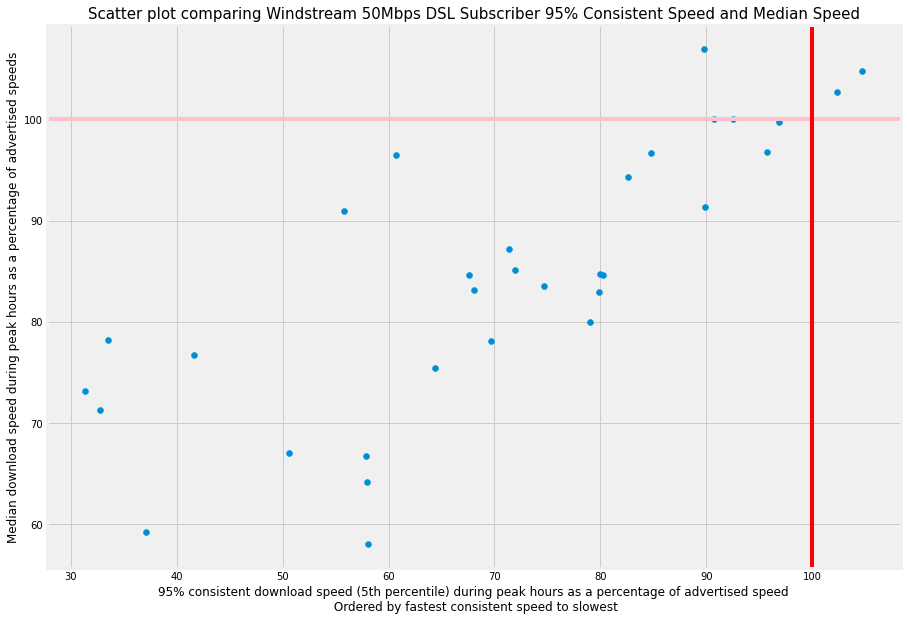

In [90]:
X =  windstream50Scatter['5PctNorm']
Y = windstream50Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

plt.axhline(y = 100, color = 'pink', linestyle = '-')
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.grid(True)
ax1.scatter(X, Y)



plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed\n Ordered by fastest consistent speed to slowest")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Windstream 50Mbps DSL Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

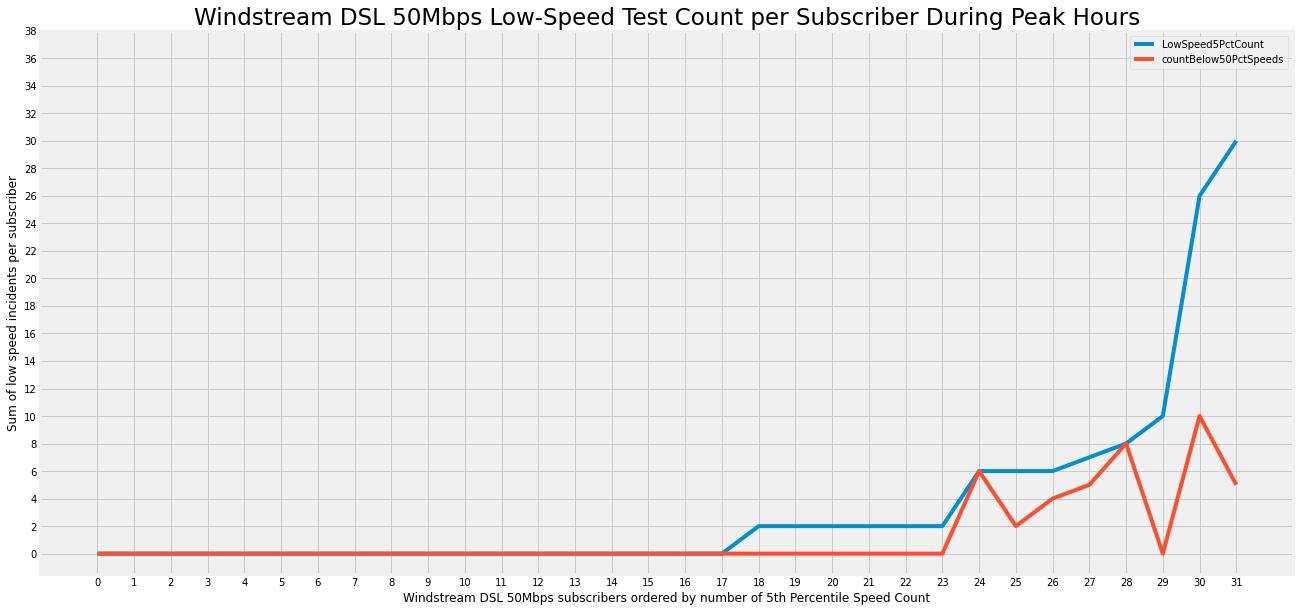

In [67]:
ax = windstream50.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 40, 2))
plt.xticks(np.arange(0, len(windstream50), 1))



ax.set_xlabel('Windstream DSL 50Mbps subscribers ordered by number of 5th Percentile Speed Count')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Windstream DSL 50Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [68]:
print(stats.kendalltau(windstream50['LowSpeed5PctCount'], windstream50['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(windstream50['LowSpeed5PctCount'], windstream50['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.37609228844697207, pvalue=0.006456824126999939)


SpearmanrResult(correlation=-0.49550519181584585, pvalue=0.003930520546023269)


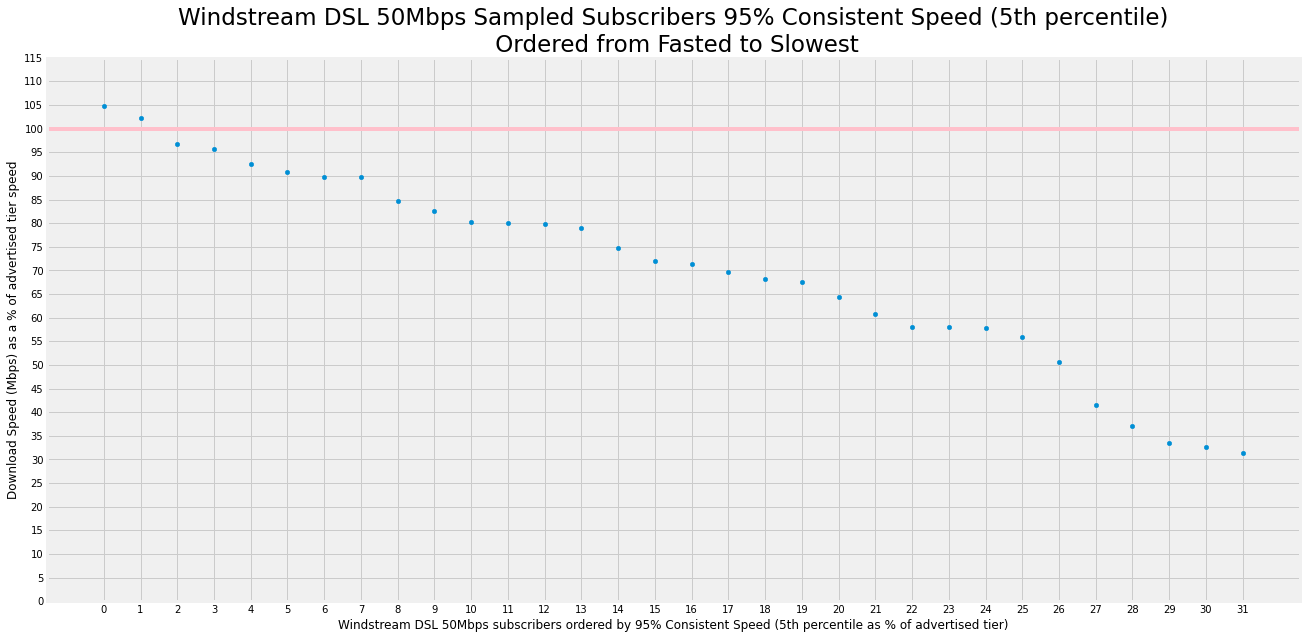

In [69]:
x=[]
for i in range(len(windstream50Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = windstream50Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 120, 5))
plt.xticks(np.arange(0, len(windstream50Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Windstream DSL 50Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Windstream DSL 50Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [70]:
windstream100

,unit_id,ISP,Technology,Download,State,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,latitude,longitude,5PctNorm,MedianNorm
0,10167,Windstream,DSL,100.0,KY,0,0,91.264944,109.683152,108.786136,37.919306,-84.645100,91.264944,108.786136
1,40206337,Windstream,DSL,100.0,GA,0,0,102.447392,105.007528,104.829728,34.554253,-83.546278,102.447392,104.829728
2,38616857,Windstream,DSL,100.0,GA,0,0,98.160352,104.994792,104.316536,34.490401,-84.000222,98.160352,104.316536
3,41194973,Windstream,DSL,100.0,GA,0,0,99.530272,99.530272,99.530272,34.518349,-83.696956,99.530272,99.530272
4,38616865,Windstream,DSL,100.0,GA,0,0,97.977392,104.766056,103.287056,33.410677,-83.891248,97.977392,103.287056
5,999625,Windstream,DSL,100.0,TX,0,0,101.815376,109.803544,109.205248,29.986697,-99.103256,101.815376,109.205248
6,32833353,Windstream,DSL,100.0,OK,0,0,85.255104,86.079520,86.044312,36.041018,-95.840700,85.255104,86.044312
7,999221,Windstream,DSL,100.0,TX,0,0,92.588168,96.993168,96.589248,29.011121,-95.704768,92.588168,96.589248
8,26226257,Windstream,DSL,100.0,TX,0,0,117.245896,118.423256,118.351912,29.659119,-95.686792,117.245896,118.351912
9,26226325,Windstream,DSL,100.0,TX,0,0,81.166992,93.939936,92.698664,31.907375,-96.608187,81.166992,92.698664


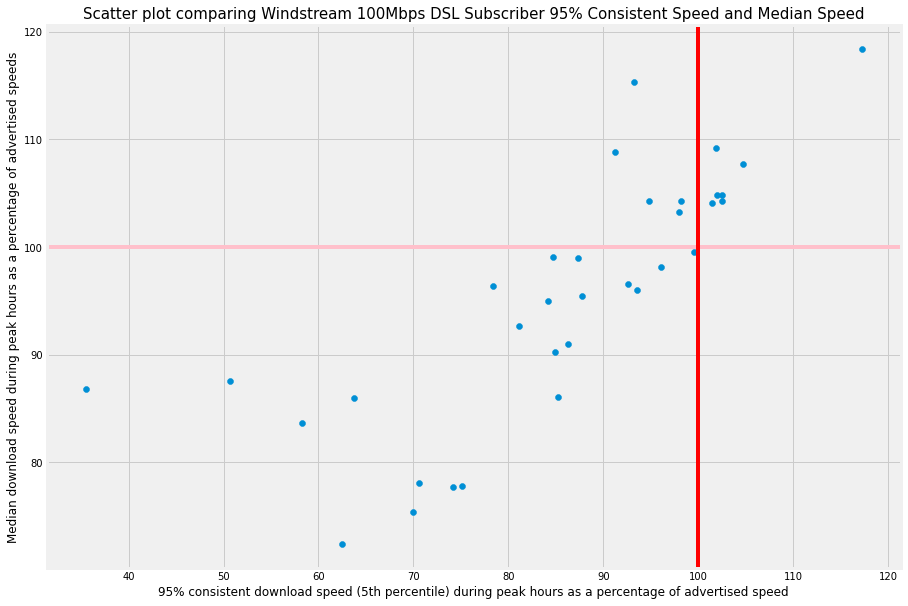

In [71]:
X =  windstream100Scatter['5PctNorm']
Y = windstream100Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)
plt.axhline(y = 100, color = 'pink', linestyle = '-')
plt.axvline(x = 100, color = 'red', linestyle = '-')

plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Windstream 100Mbps DSL Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

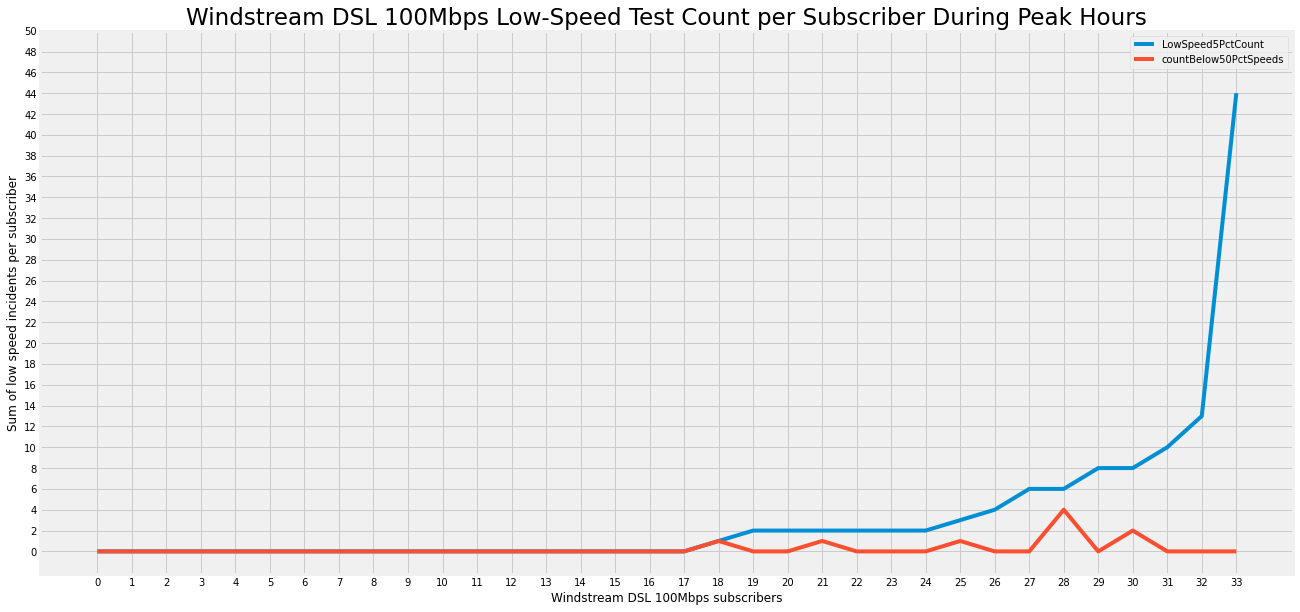

In [72]:
ax = windstream100.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 52, 2))
plt.xticks(np.arange(0, len(windstream100), 1))


ax.set_xlabel('Windstream DSL 100Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Windstream DSL 100Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [73]:
print(stats.kendalltau(windstream100['LowSpeed5PctCount'], windstream100['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(windstream100['LowSpeed5PctCount'], windstream100['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.33949025698194063, pvalue=0.01012443904559711)


SpearmanrResult(correlation=-0.44294775784484697, pvalue=0.008703355669781815)


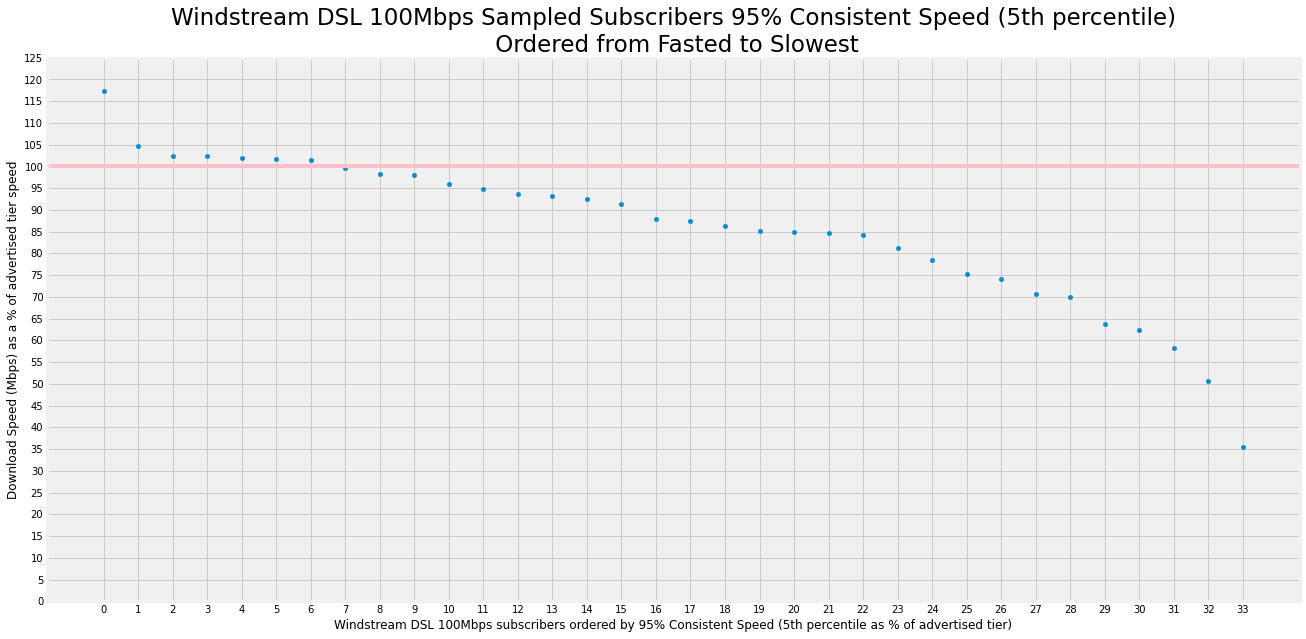

In [74]:
x=[]
for i in range(len(windstream100Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = windstream100Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 130, 5))
plt.xticks(np.arange(0, len(windstream100Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Windstream DSL 100Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Windstream DSL 100Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [75]:
mediacom500

,unit_id,ISP,Technology,Download,State,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,latitude,longitude,5PctNorm,MedianNorm
0,39876973,Mediacom,Cable,500.0,IA,0,0,545.434672,572.286600,571.158496,42.444643,-92.393739,109.086934,114.231699
1,38513293,Mediacom,Cable,500.0,IL,0,0,552.315512,570.932856,566.335896,42.335210,-88.880200,110.463102,113.267179
2,26437521,Mediacom,Cable,500.0,MO,0,0,548.032840,572.322704,571.345536,37.344285,-92.900934,109.606568,114.269107
3,38658737,Mediacom,Cable,500.0,IA,0,0,570.860992,571.236544,570.885464,42.491084,-92.354597,114.172198,114.177093
4,38616913,Mediacom,Cable,500.0,IA,0,0,515.437096,566.305240,559.623296,43.157247,-93.224284,103.087419,111.924659
5,38513353,Mediacom,Cable,500.0,MN,0,0,536.477112,572.181744,568.804512,47.529494,-92.244624,107.295422,113.760902
6,38658733,Mediacom,Cable,500.0,MO,0,0,554.161104,572.130520,569.262872,37.226533,-93.269363,110.832221,113.852574
7,38513393,Mediacom,Cable,500.0,IA,0,0,568.106528,571.289688,570.830112,42.010436,-91.729724,113.621306,114.166022
8,38513533,Mediacom,Cable,500.0,IN,0,0,556.905624,567.966584,562.447744,41.307132,-85.697973,111.381125,112.489549
9,26827337,Mediacom,Cable,500.0,IA,0,0,564.362160,571.368360,570.655536,42.467088,-92.368244,112.872432,114.131107


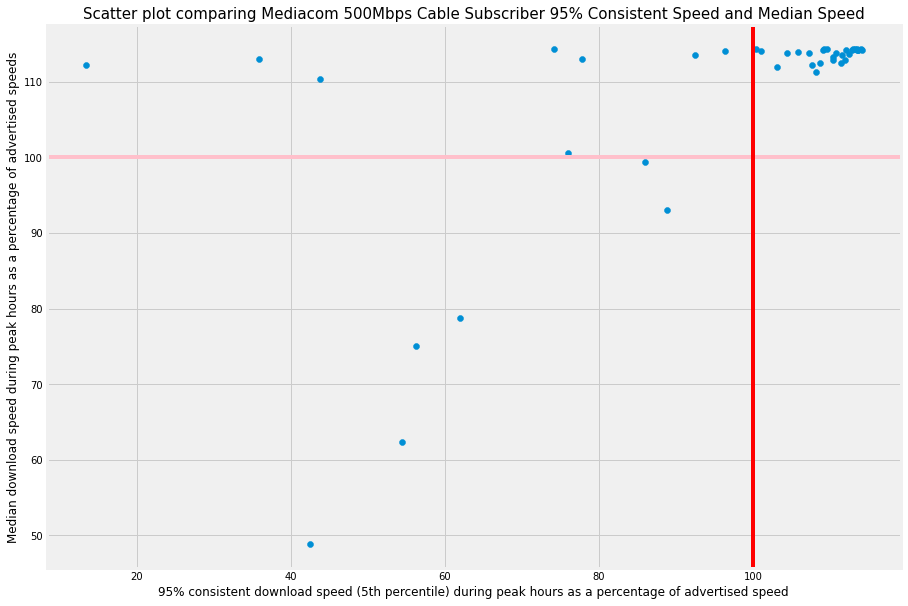

In [76]:
X =  mediacom500Scatter['5PctNorm']
Y = mediacom500Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axhline(y = 100, color = 'pink', linestyle = '-')
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Mediacom 500Mbps Cable Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

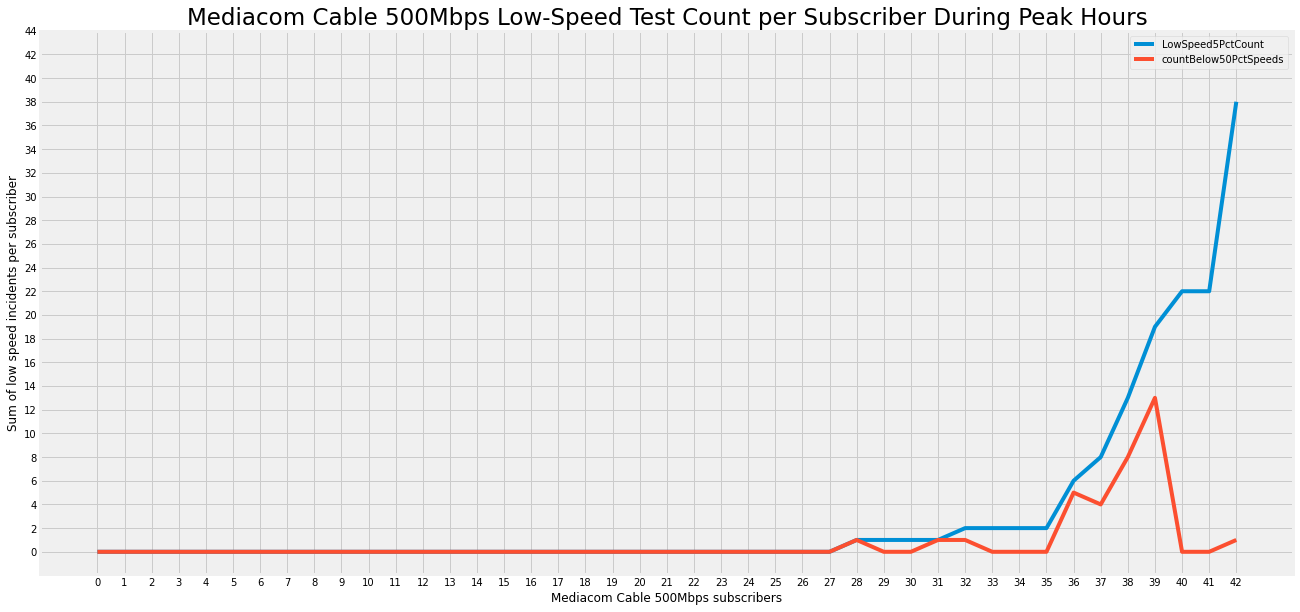

In [77]:
ax = mediacom500.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 46, 2))
plt.xticks(np.arange(0, len(mediacom500), 1))


ax.set_xlabel('Mediacom Cable 500Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Mediacom Cable 500Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [78]:
print(stats.kendalltau(mediacom500['LowSpeed5PctCount'], mediacom500['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(mediacom500['LowSpeed5PctCount'], mediacom500['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.17648280200062935, pvalue=0.1381475024655372)


SpearmanrResult(correlation=-0.2465018165777769, pvalue=0.111050723327667)


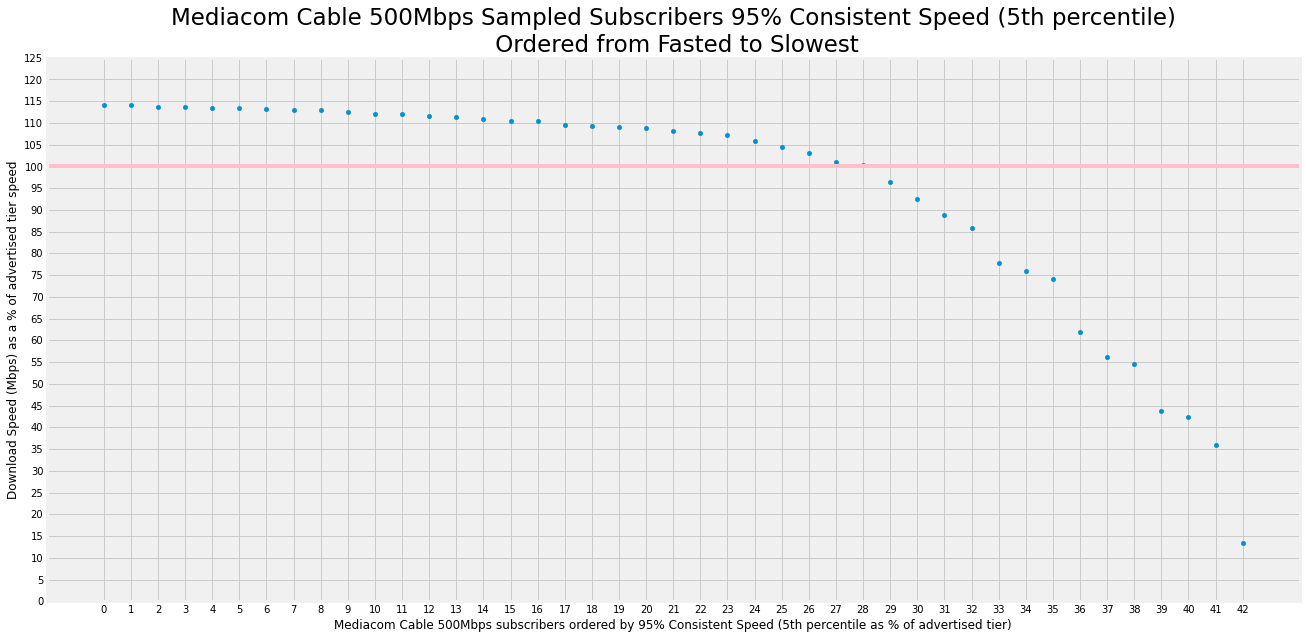

In [79]:
x=[]
for i in range(len(mediacom500Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = mediacom500Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 130, 5))
plt.xticks(np.arange(0, len(mediacom500Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Mediacom Cable 500Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Mediacom Cable 500Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [80]:
comcast500

,unit_id,ISP,Technology,Download,State,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,latitude,longitude,5PctNorm,MedianNorm
0,38713617,Comcast,Cable,500.0,CA,0,0,589.154120,596.241080,594.795600,37.786381,-122.423388,117.830824,118.959120
1,38713301,Comcast,Cable,500.0,CA,0,0,592.538304,596.243288,595.272280,37.227283,-121.931049,118.507661,119.054456
2,24030797,Comcast,Cable,500.0,CA,0,0,558.664856,596.192696,589.371288,37.359304,-122.002405,111.732971,117.874258
3,24525689,Comcast,Cable,500.0,CA,0,0,589.179832,596.091816,595.196400,37.761612,-121.911863,117.835966,119.039280
4,25834681,Comcast,Cable,500.0,CO,0,0,586.442024,595.284712,595.258656,38.866291,-104.931000,117.288405,119.051731
5,24767593,Comcast,Cable,500.0,CA,0,0,592.428728,595.071392,592.432912,38.670411,-121.379394,118.485746,118.486582
6,4114285,Comcast,Cable,500.0,OR,0,0,581.479968,596.556824,592.488792,45.008890,-123.036685,116.295994,118.497758
7,24840645,Comcast,Cable,500.0,WA,0,0,389.582960,546.714472,505.428320,47.207812,-122.137877,77.916592,101.085664
8,4040429,Comcast,Cable,500.0,WA,0,2,576.629080,597.113480,593.271264,47.696579,-122.099228,115.325816,118.654253
9,25657945,Comcast,Cable,500.0,WA,0,0,446.949312,581.159448,537.783312,47.081171,-122.751943,89.389862,107.556662


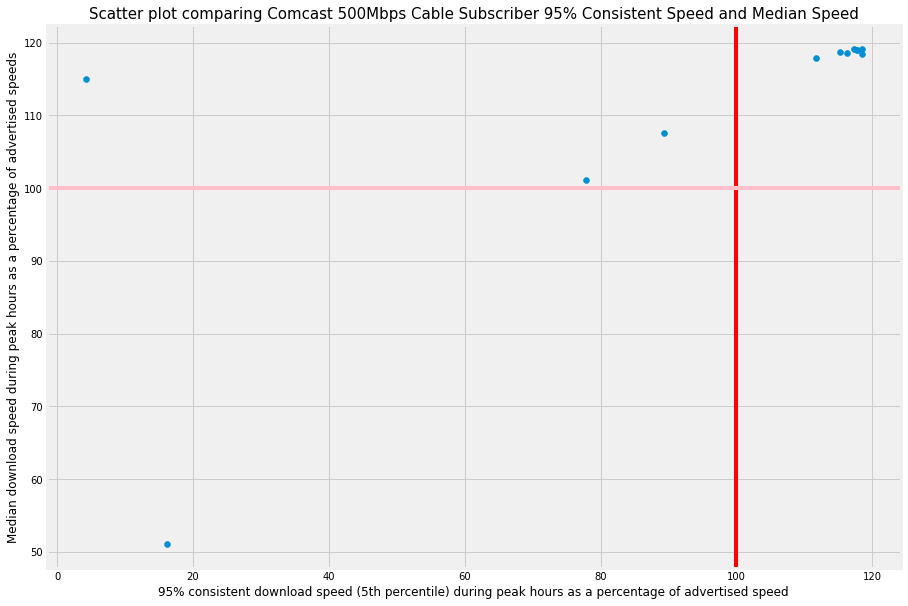

In [81]:
X =  comcast500Scatter['5PctNorm']
Y = comcast500Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.axhline(y = 100, color = 'pink', linestyle = '-')

plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Comcast 500Mbps Cable Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

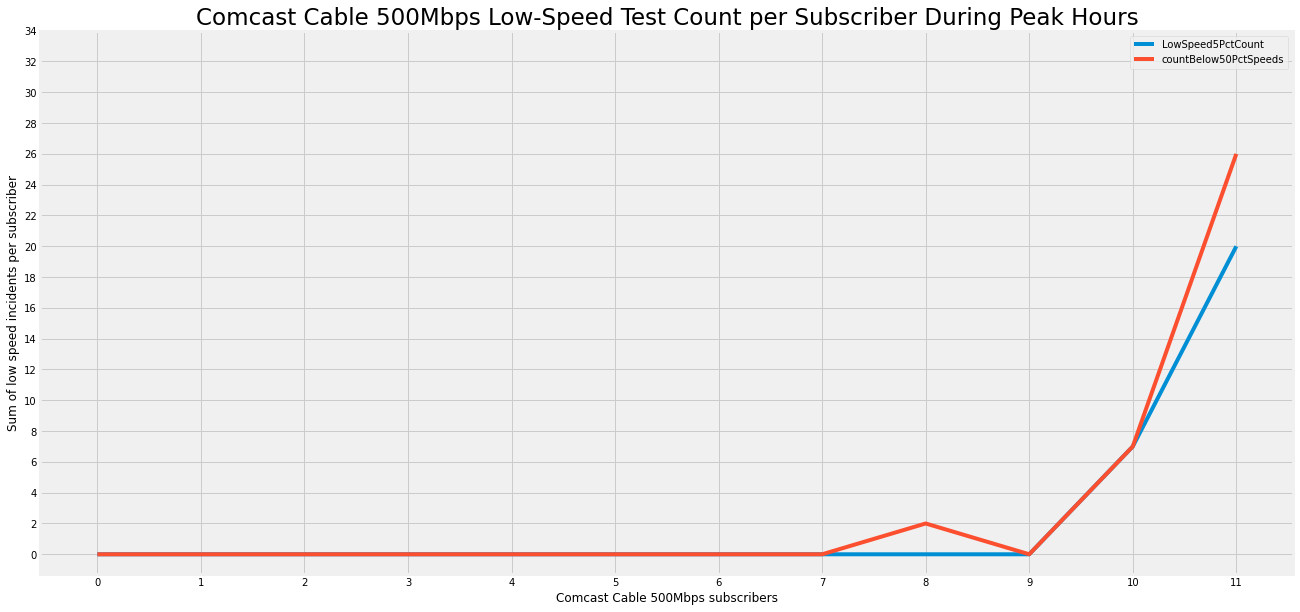

In [82]:
ax = comcast500.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 36, 2))
plt.xticks(np.arange(0, len(comcast500), 1))

ax.set_xlabel('Comcast Cable 500Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Comcast Cable 500Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [83]:
print(stats.kendalltau(comcast500['LowSpeed5PctCount'], comcast500['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(comcast500['LowSpeed5PctCount'], comcast500['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.2954684201426394, pvalue=0.240062291152626)


SpearmanrResult(correlation=-0.38166527377477155, pvalue=0.22086746731076976)


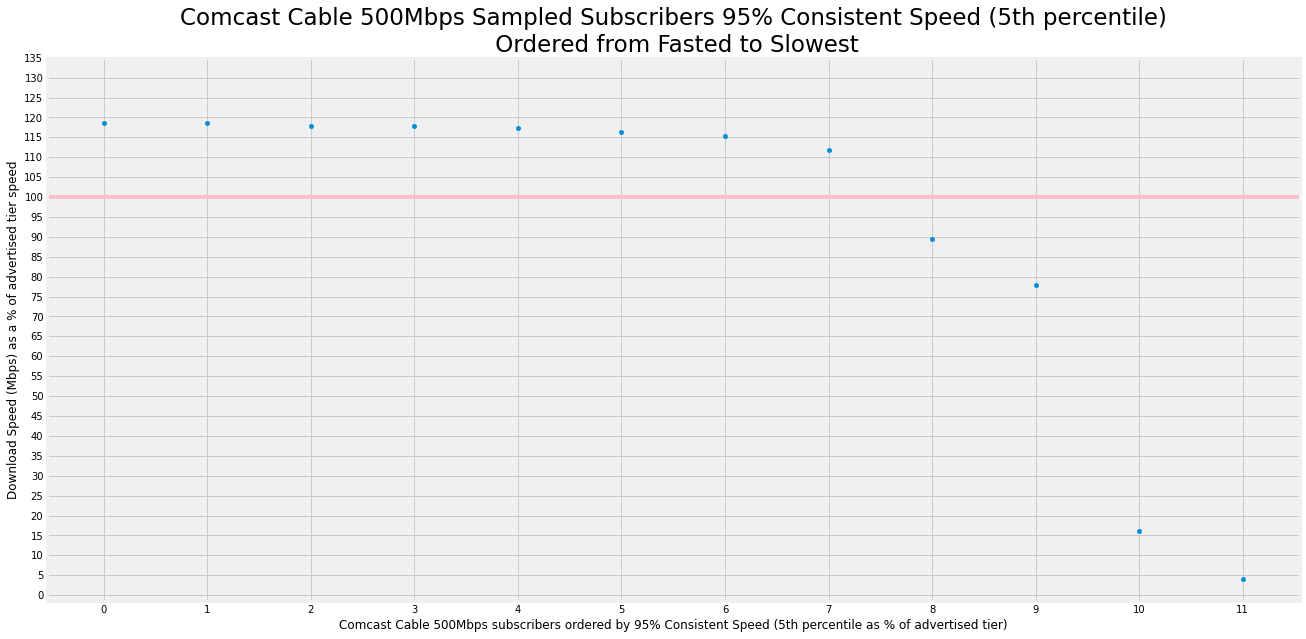

In [84]:
x=[]
for i in range(len(comcast500Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = comcast500Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 140, 5))
plt.xticks(np.arange(0, len(comcast500Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Comcast Cable 500Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Comcast Cable 500Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [85]:
frontier500

,unit_id,ISP,Technology,Download,State,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,latitude,longitude,5PctNorm,MedianNorm
0,39774565,Frontier,Fiber,500.0,TX,0,0,497.512480,508.576024,505.973152,33.039898,-96.587212,99.502496,101.194630
1,39876837,Frontier,Fiber,500.0,CA,0,0,498.071064,504.531296,499.652288,33.734152,-117.976203,99.614213,99.930458
2,25886969,Frontier,Fiber,500.0,CA,0,0,480.822280,504.615456,500.343920,33.564066,-117.146305,96.164456,100.068784
3,38098225,Frontier,Fiber,500.0,CA,0,0,495.230904,502.030752,501.060704,33.858320,-118.388144,99.046181,100.212141
4,38098173,Frontier,Fiber,500.0,CA,0,0,494.850200,510.068568,509.524752,34.225688,-119.202694,98.970040,101.904950
5,39876969,Frontier,Fiber,500.0,CA,0,0,501.963808,509.052136,507.789592,34.037390,-117.078858,100.392762,101.557918
6,3894093,Frontier,Fiber,500.0,CA,0,0,477.180160,501.288152,493.550768,33.901305,-117.296751,95.436032,98.710154
7,24839733,Frontier,Fiber,500.0,CA,0,0,495.938552,509.729520,503.123672,34.007468,-117.588351,99.187710,100.624734
8,24839925,Frontier,Fiber,500.0,CA,0,0,488.114696,503.514880,498.926616,33.749487,-116.240538,97.622939,99.785323
9,38407149,Frontier,Fiber,500.0,CA,0,0,489.919768,505.361448,504.884192,34.078478,-117.983530,97.983954,100.976838


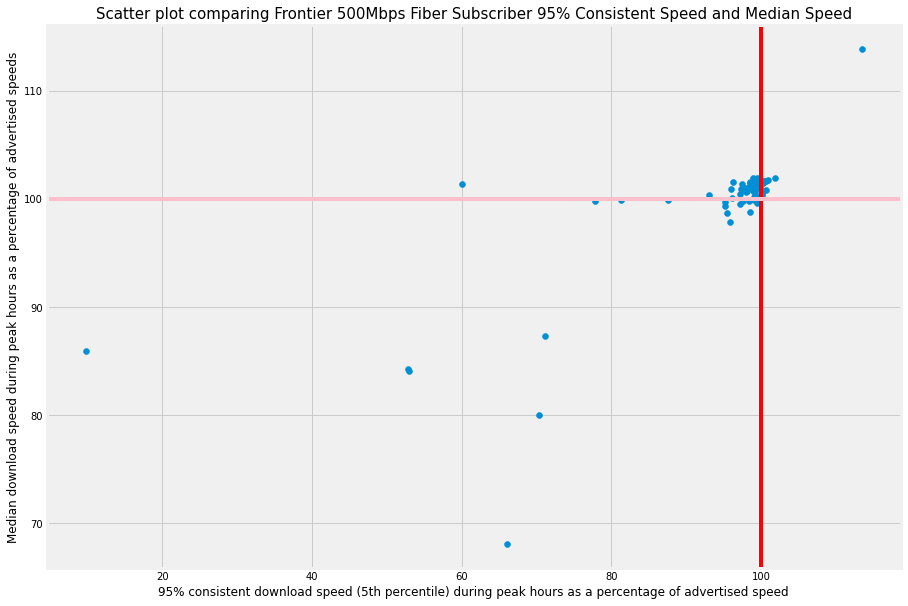

In [86]:
X =  frontier500Scatter['5PctNorm']
Y = frontier500Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.axhline(y = 100, color = 'pink', linestyle = '-')


plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Frontier 500Mbps Fiber Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

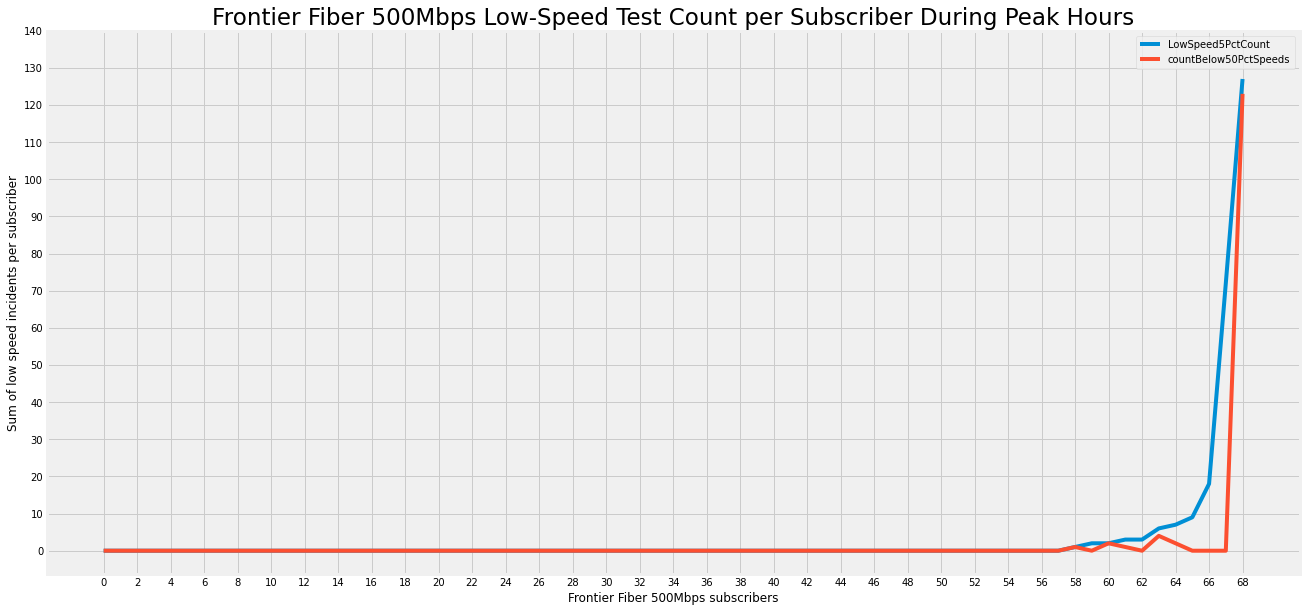

In [87]:
ax = frontier500.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 150, 10))
plt.xticks(np.arange(0, len(frontier500), 2))

ax.set_xlabel('Frontier Fiber 500Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Frontier Fiber 500Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [88]:
print(stats.kendalltau(frontier500['LowSpeed5PctCount'], frontier500['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(frontier500['LowSpeed5PctCount'], frontier500['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.2552585708713601, pvalue=0.008067503364372898)


SpearmanrResult(correlation=-0.3185803278694842, pvalue=0.007633117409186123)


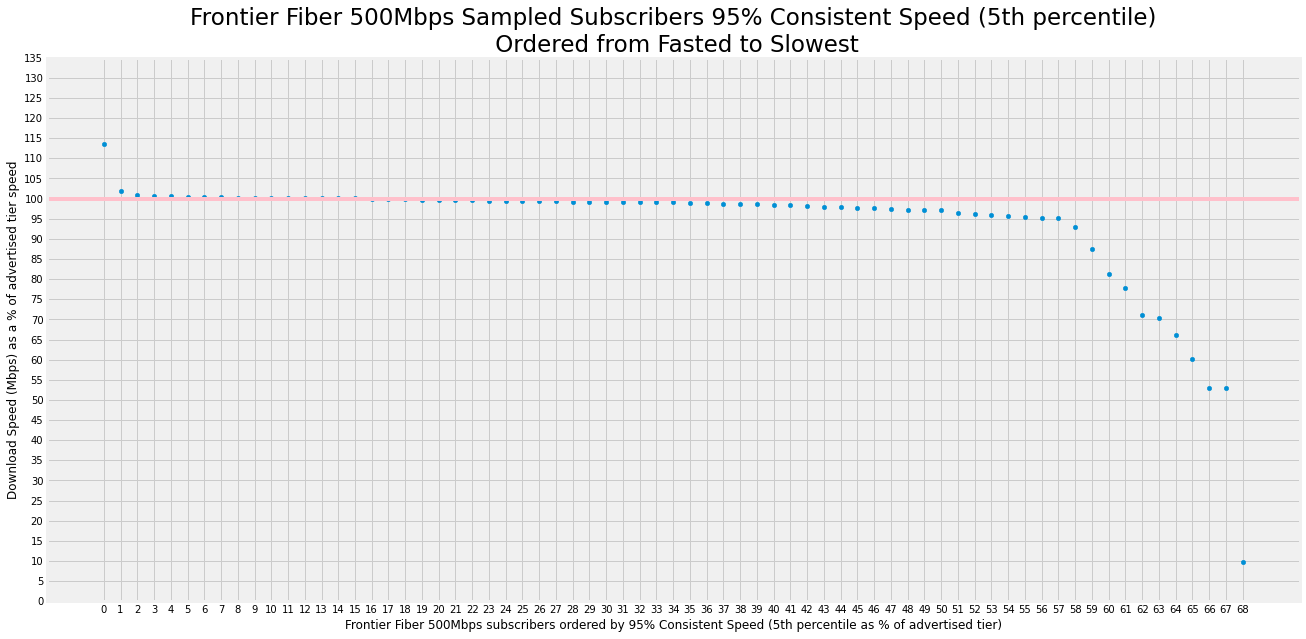

In [89]:
x=[]
for i in range(len(frontier500Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = frontier500Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 5))
plt.xticks(np.arange(0, len(frontier500Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Frontier Fiber 500Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Frontier Fiber 500Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()